[55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]
[ 27.  35.  35.  56.  64. 105. 140. 166. 229. 295.]
[0.3        0.37777778 0.45555556 0.53333333 0.61111111 0.68888889
 0.76666667 0.84444444 0.92222222 1.        ]
[0.3        0.32089552 0.32089552 0.37574627 0.39664179 0.50373134
 0.59514925 0.6630597  0.82761194 1.        ]
x0 = 1.1812705590904415
y0 = 0.251543385489762
c = 2.45606563978802
k = 4.573022267123975

x0 = 52.32412770194759
y0 = 8.448039016080317
c = 940.322273518842
k = 0.35567950966519807
asymptot = 948.7703125349224
flex = 0.019791746520098793,0.26360375708669004



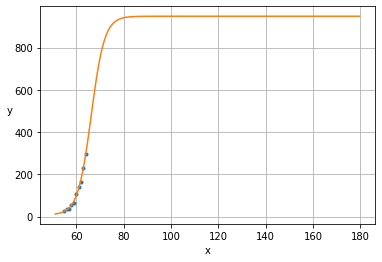

In [2]:
import mytools.regression

## test